# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


# Preprocessing
Feature engineering, create categorial columns

In [147]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# FEATURE ENGINEERING
## month
df_train['Month'] = pd.DatetimeIndex(df_train['Date']).to_period('M')
df_train['Year'] = pd.DatetimeIndex(df_train['Date']).to_period('Y')
df_train['Month_str'] = df_train['Month'].map(lambda month_period:month_period.strftime('%Y-%m'))

## StateHoliday -> categorial
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')

## StateHoliday -> categorial
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')

df_train.info()
df_train.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  category      
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  category      
 8   SchoolHoliday  1017209 non-null  bool          
 9   Month          1017209 non-null  period[M]     
 10  Year           1017209 non-null  period[A-DEC] 
 11  Month_str      1017209 non-null  object        
dtypes: bool(3), category(2), datetime64[ns](1), int64(3), object(1), period[A-DEC](1), period[M](1)
memory usage: 59.2+ MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,Month_str
0,1,5,2015-07-31,5263,555,True,True,0,True,2015-07,2015,2015-07
1,2,5,2015-07-31,6064,625,True,True,0,True,2015-07,2015,2015-07
2,3,5,2015-07-31,8314,821,True,True,0,True,2015-07,2015,2015-07
3,4,5,2015-07-31,13995,1498,True,True,0,True,2015-07,2015,2015-07
4,5,5,2015-07-31,4822,559,True,True,0,True,2015-07,2015,2015-07


# Per store analysis
In the following analysis per ONE store id is done and data prepared to be able to forecast sales for one store

## Seasonality
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months, every 1 week, every 4 months, and so on.
Let us check if our time series has some seasonality element to it.

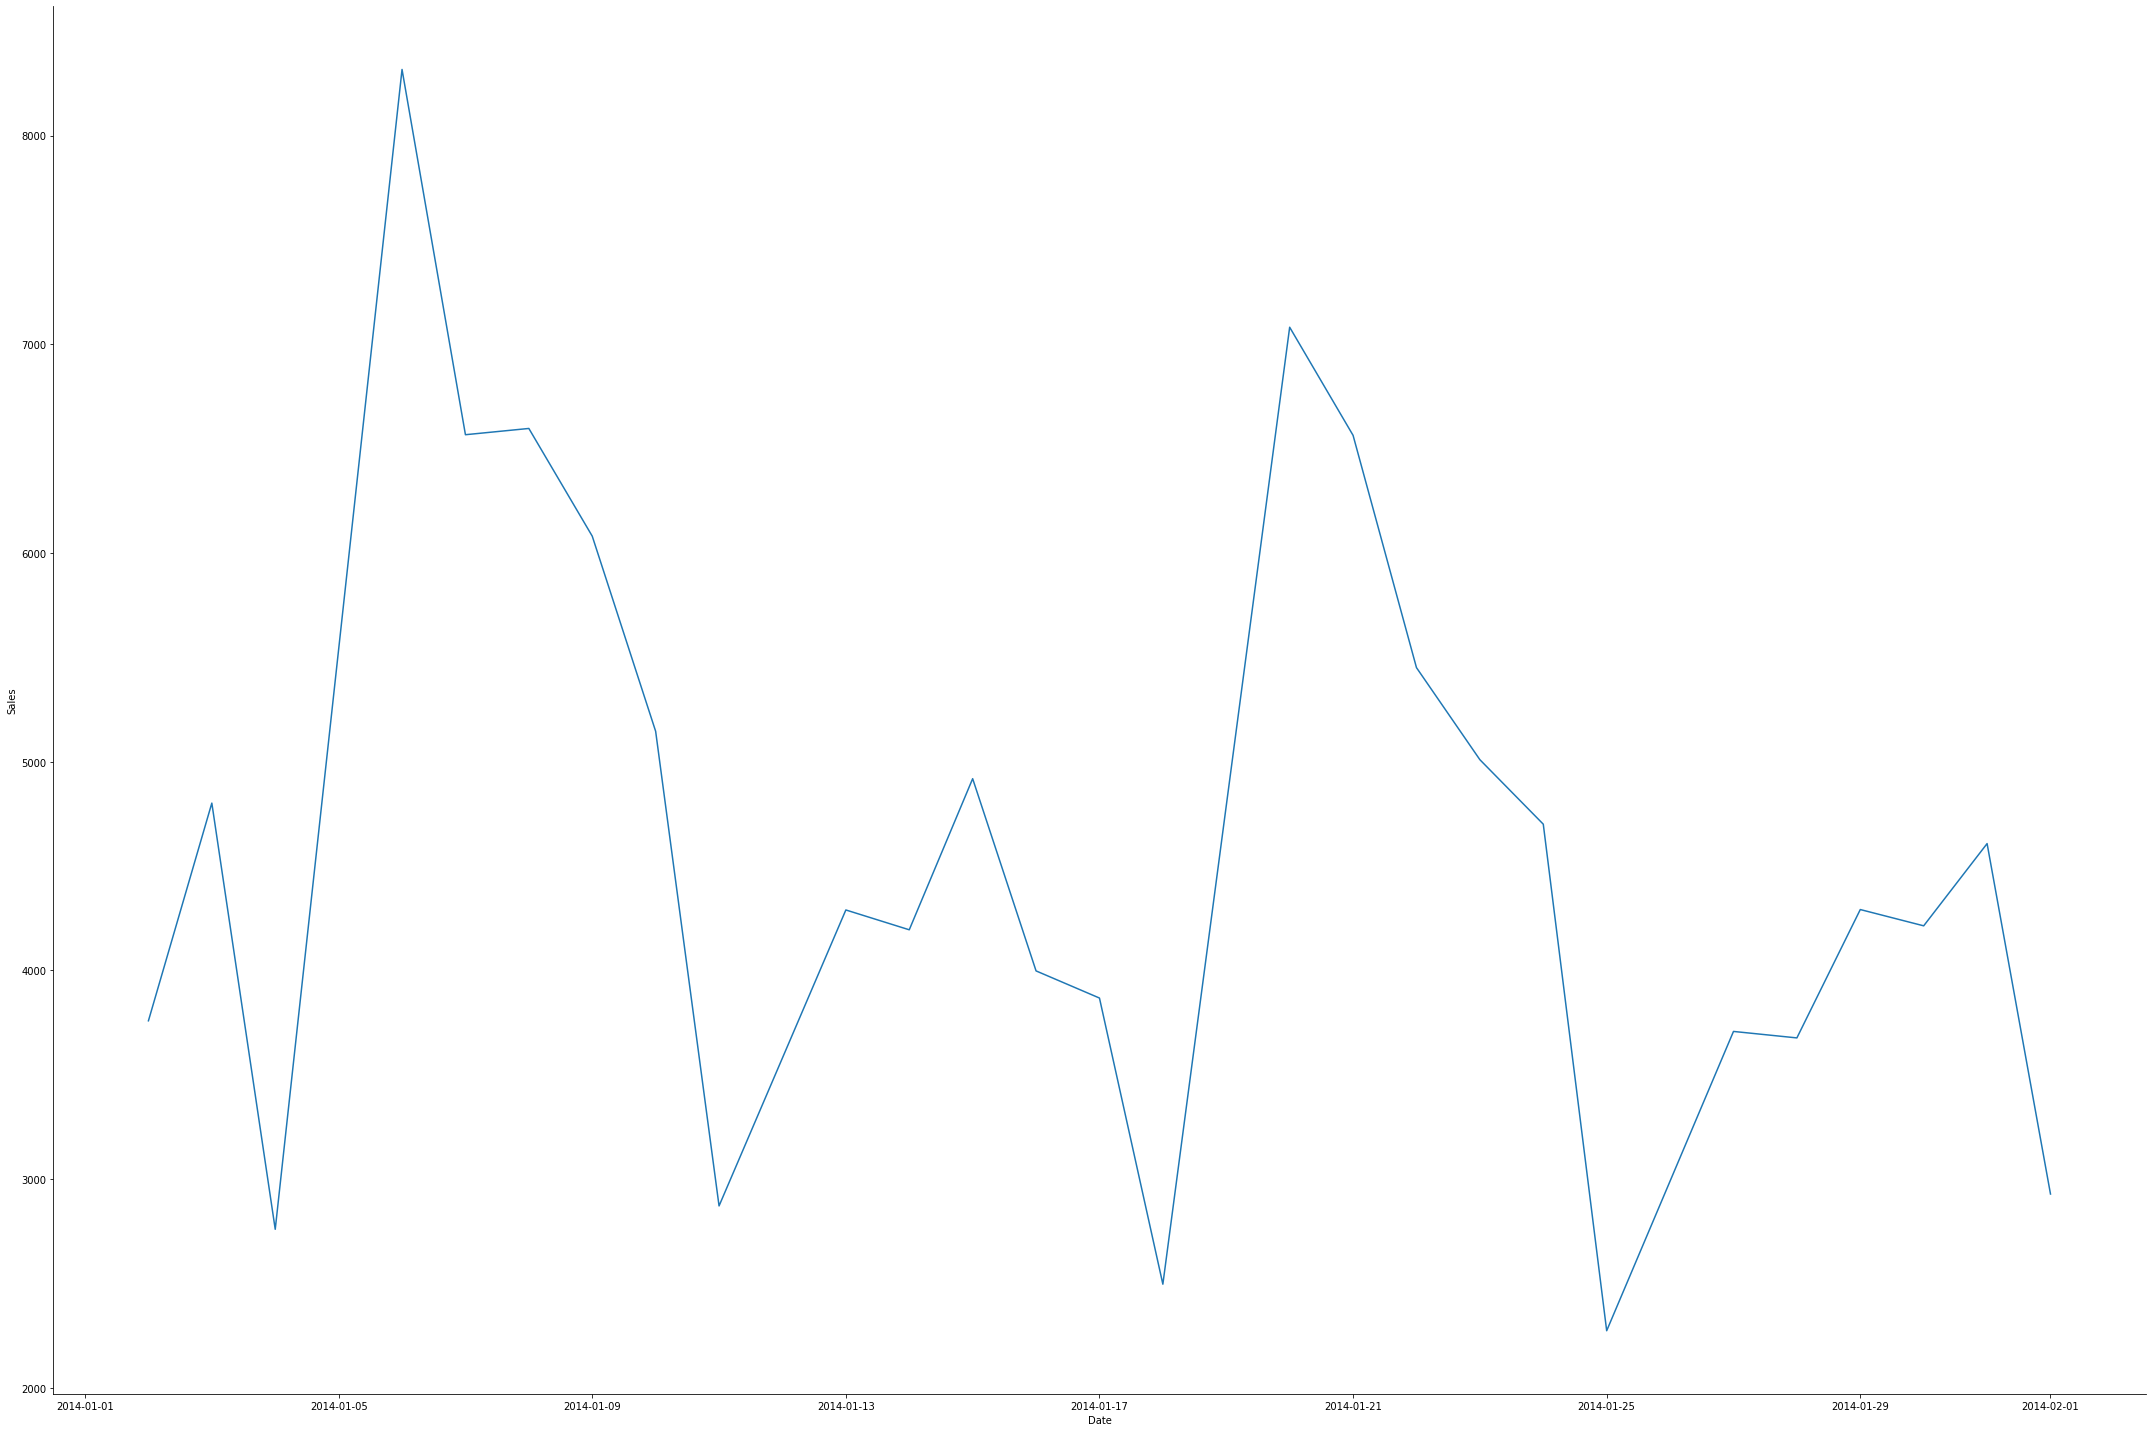

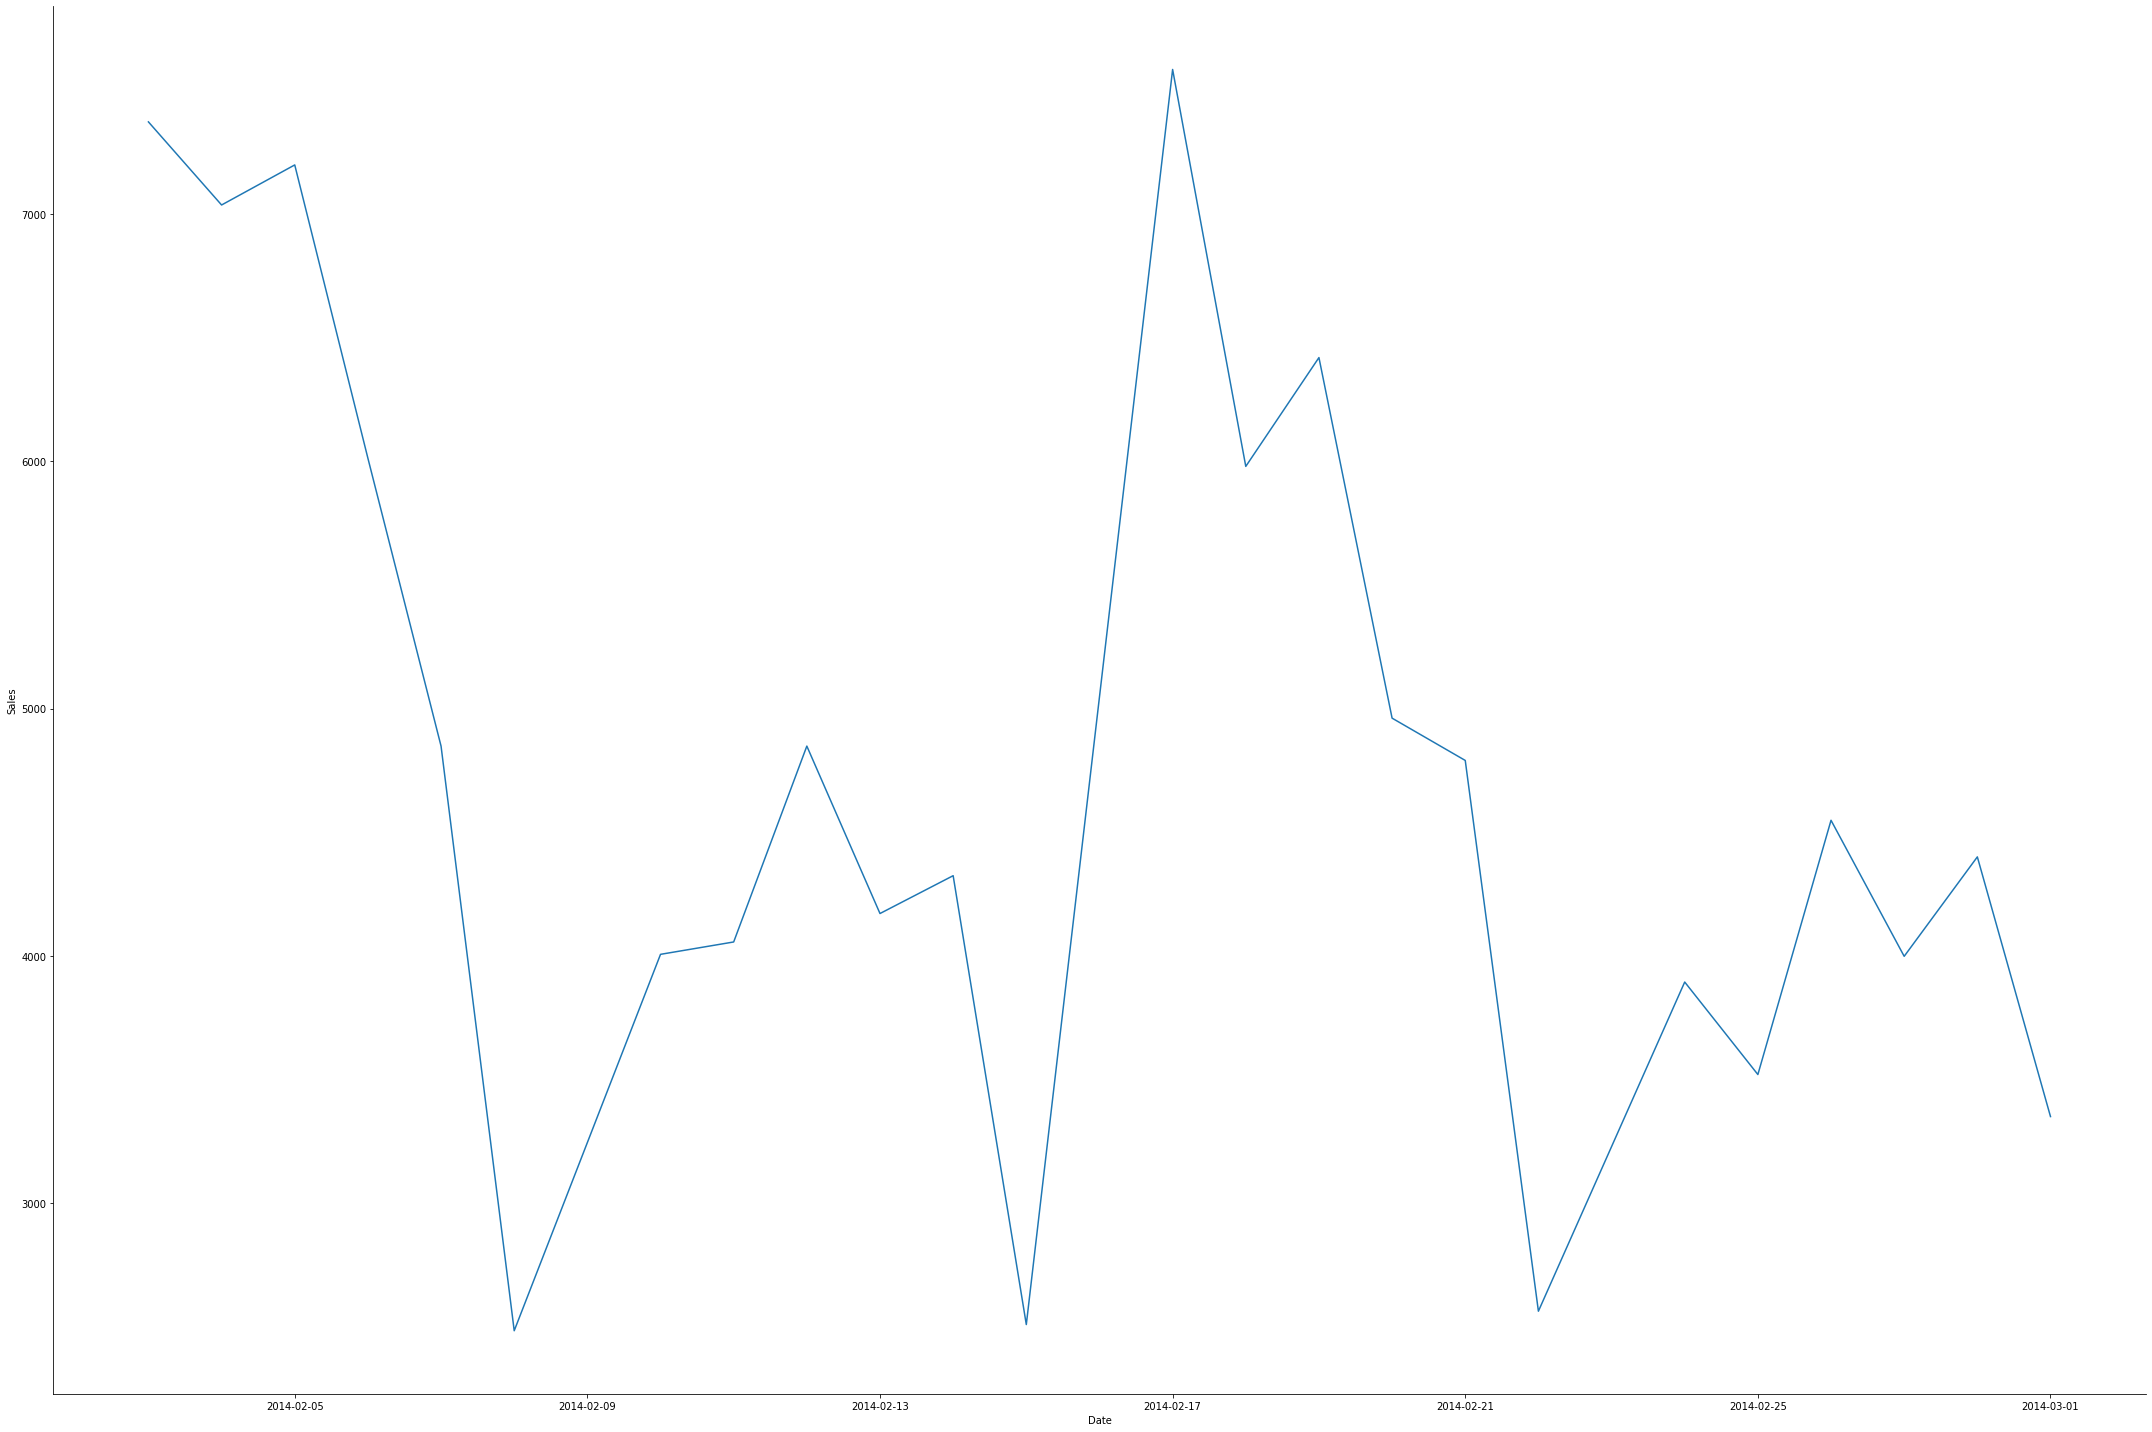

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_train_store_1 = df_train_stores.get_group(2).set_index('Date')
sales_zero_idx = df_train_store_1[df_train_store_1['Sales'] == 0].index
df_train_store_1 = df_train_store_1.drop(sales_zero_idx)
#df_train_store_1['2015-01-01':'2015-02-01'].tail(10)
#df_train_store_1.head(10)

def avg_sales_per_period(df: DataFrame) -> pd.Series:
    df_copy = df.copy()
    s_tmp: pd.Series = df['Sales'] / df['Open']
    df_copy['Sales_per_open_days_avg'] = s_tmp.astype('int')
    return df_copy

# resample/groupby MONTH
df_store_1_monthly_sum: DataFrame = df_train_store_1.resample("M").sum()
df_store_1_monthly_sum['Month'] = df_store_1_monthly_sum.index.month
df_store_1_monthly_sum['Year'] = df_store_1_monthly_sum.index.year
df_store_1_monthly_sum = avg_sales_per_period(df_store_1_monthly_sum)
# df_store_1_monthly_sum.head(5)

# Sales per Store hue'ed by all months, column for n stores
for interval in [("2014-{}-01".format(month), "2014-{}-01".format(month+1)) for month in range(1, 3)]:
    sns.relplot(data=df_train_store_1[interval[0]:interval[1]], x="Date", y="Sales", kind='line', height=20.0, aspect=1.5)
    plt.show()


# Auto-regression | Analysis

Here we try to use auto-regressive analysis to see whether there is a auto-correlation between defined lags

In [153]:
from seaborn import histplot, relplot
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from dask.dataframe import Series

def plot_series_acf_histogram(Yt: Series, lags=5, plot_lag_plot=False, hist_bins=15):
    # Yt
    relplot(data=Yt,
                kind='line',
                markers=True,
                height=20.0, aspect=1.5)
    plt.show()

    # ACF
    f = plot_acf(Yt, lags=lags)
    plt.show()

    ax = histplot(Yt, bins=hist_bins, kde=True)
    plt.show()

    # Lag plot
    if (plot_lag_plot is True):
        ax = lag_plot(series=df_store_1_monthly_sum['Sales_per_open_days_avg'], lag=lags)
        plt.show()


## ARIMA | Explorative using differencing

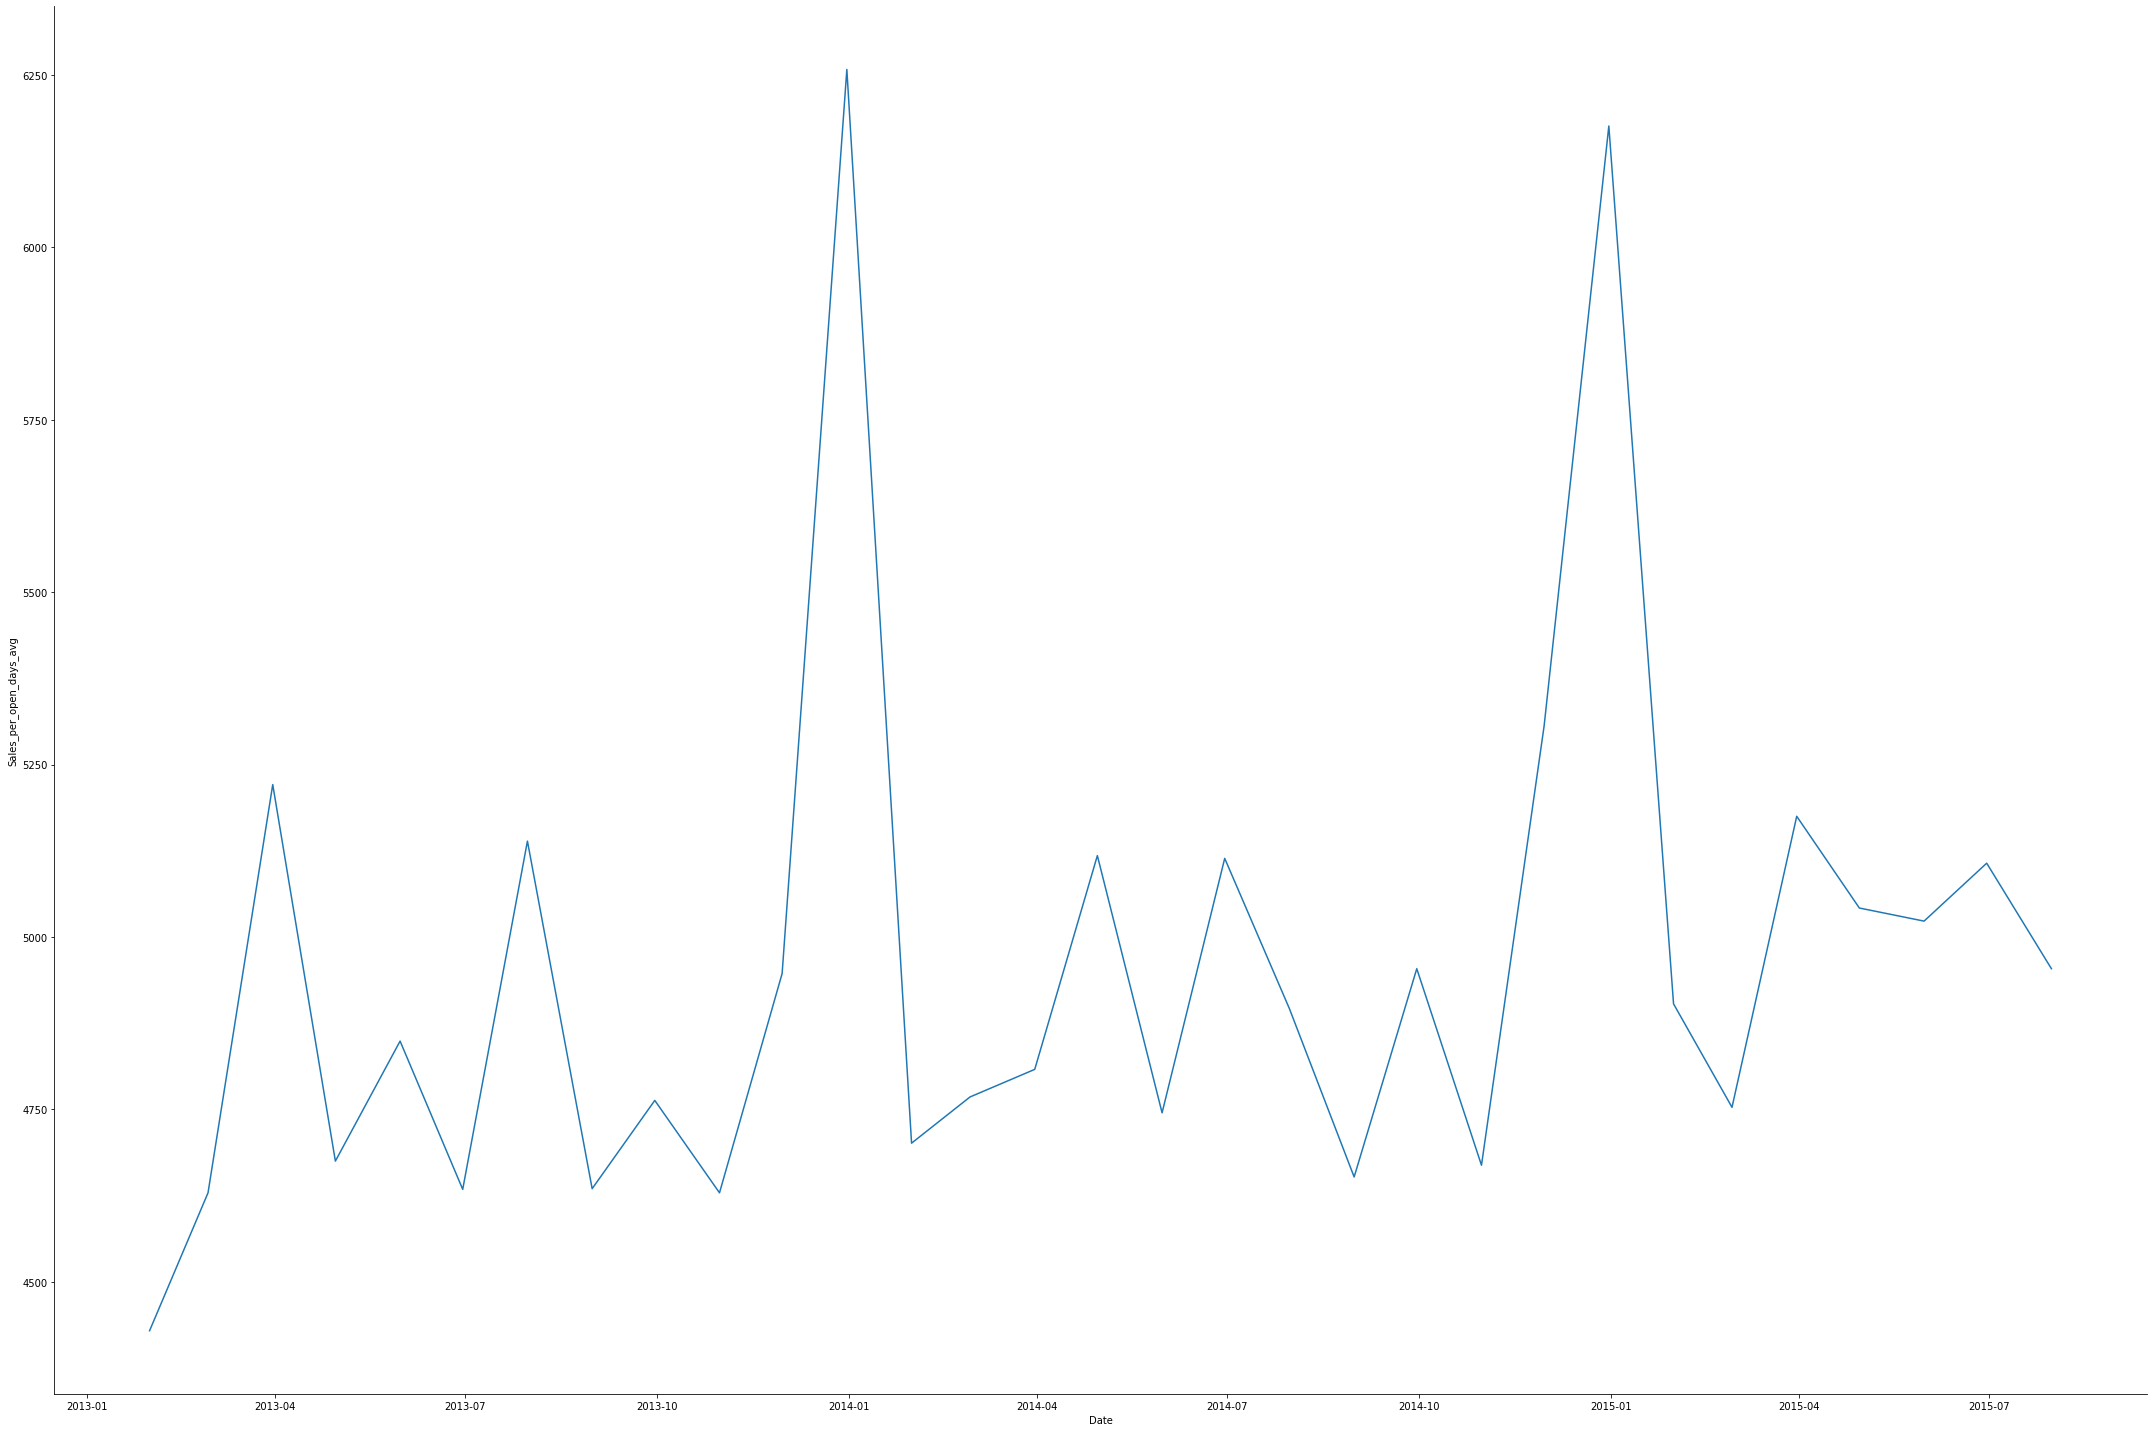

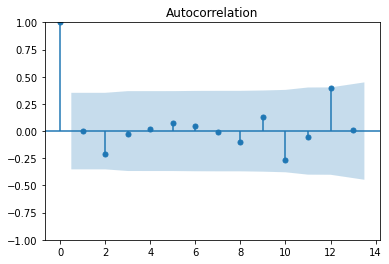

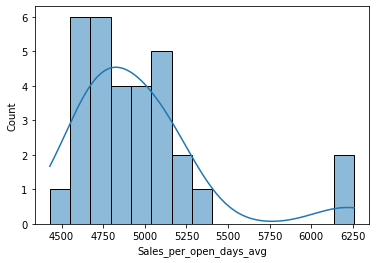

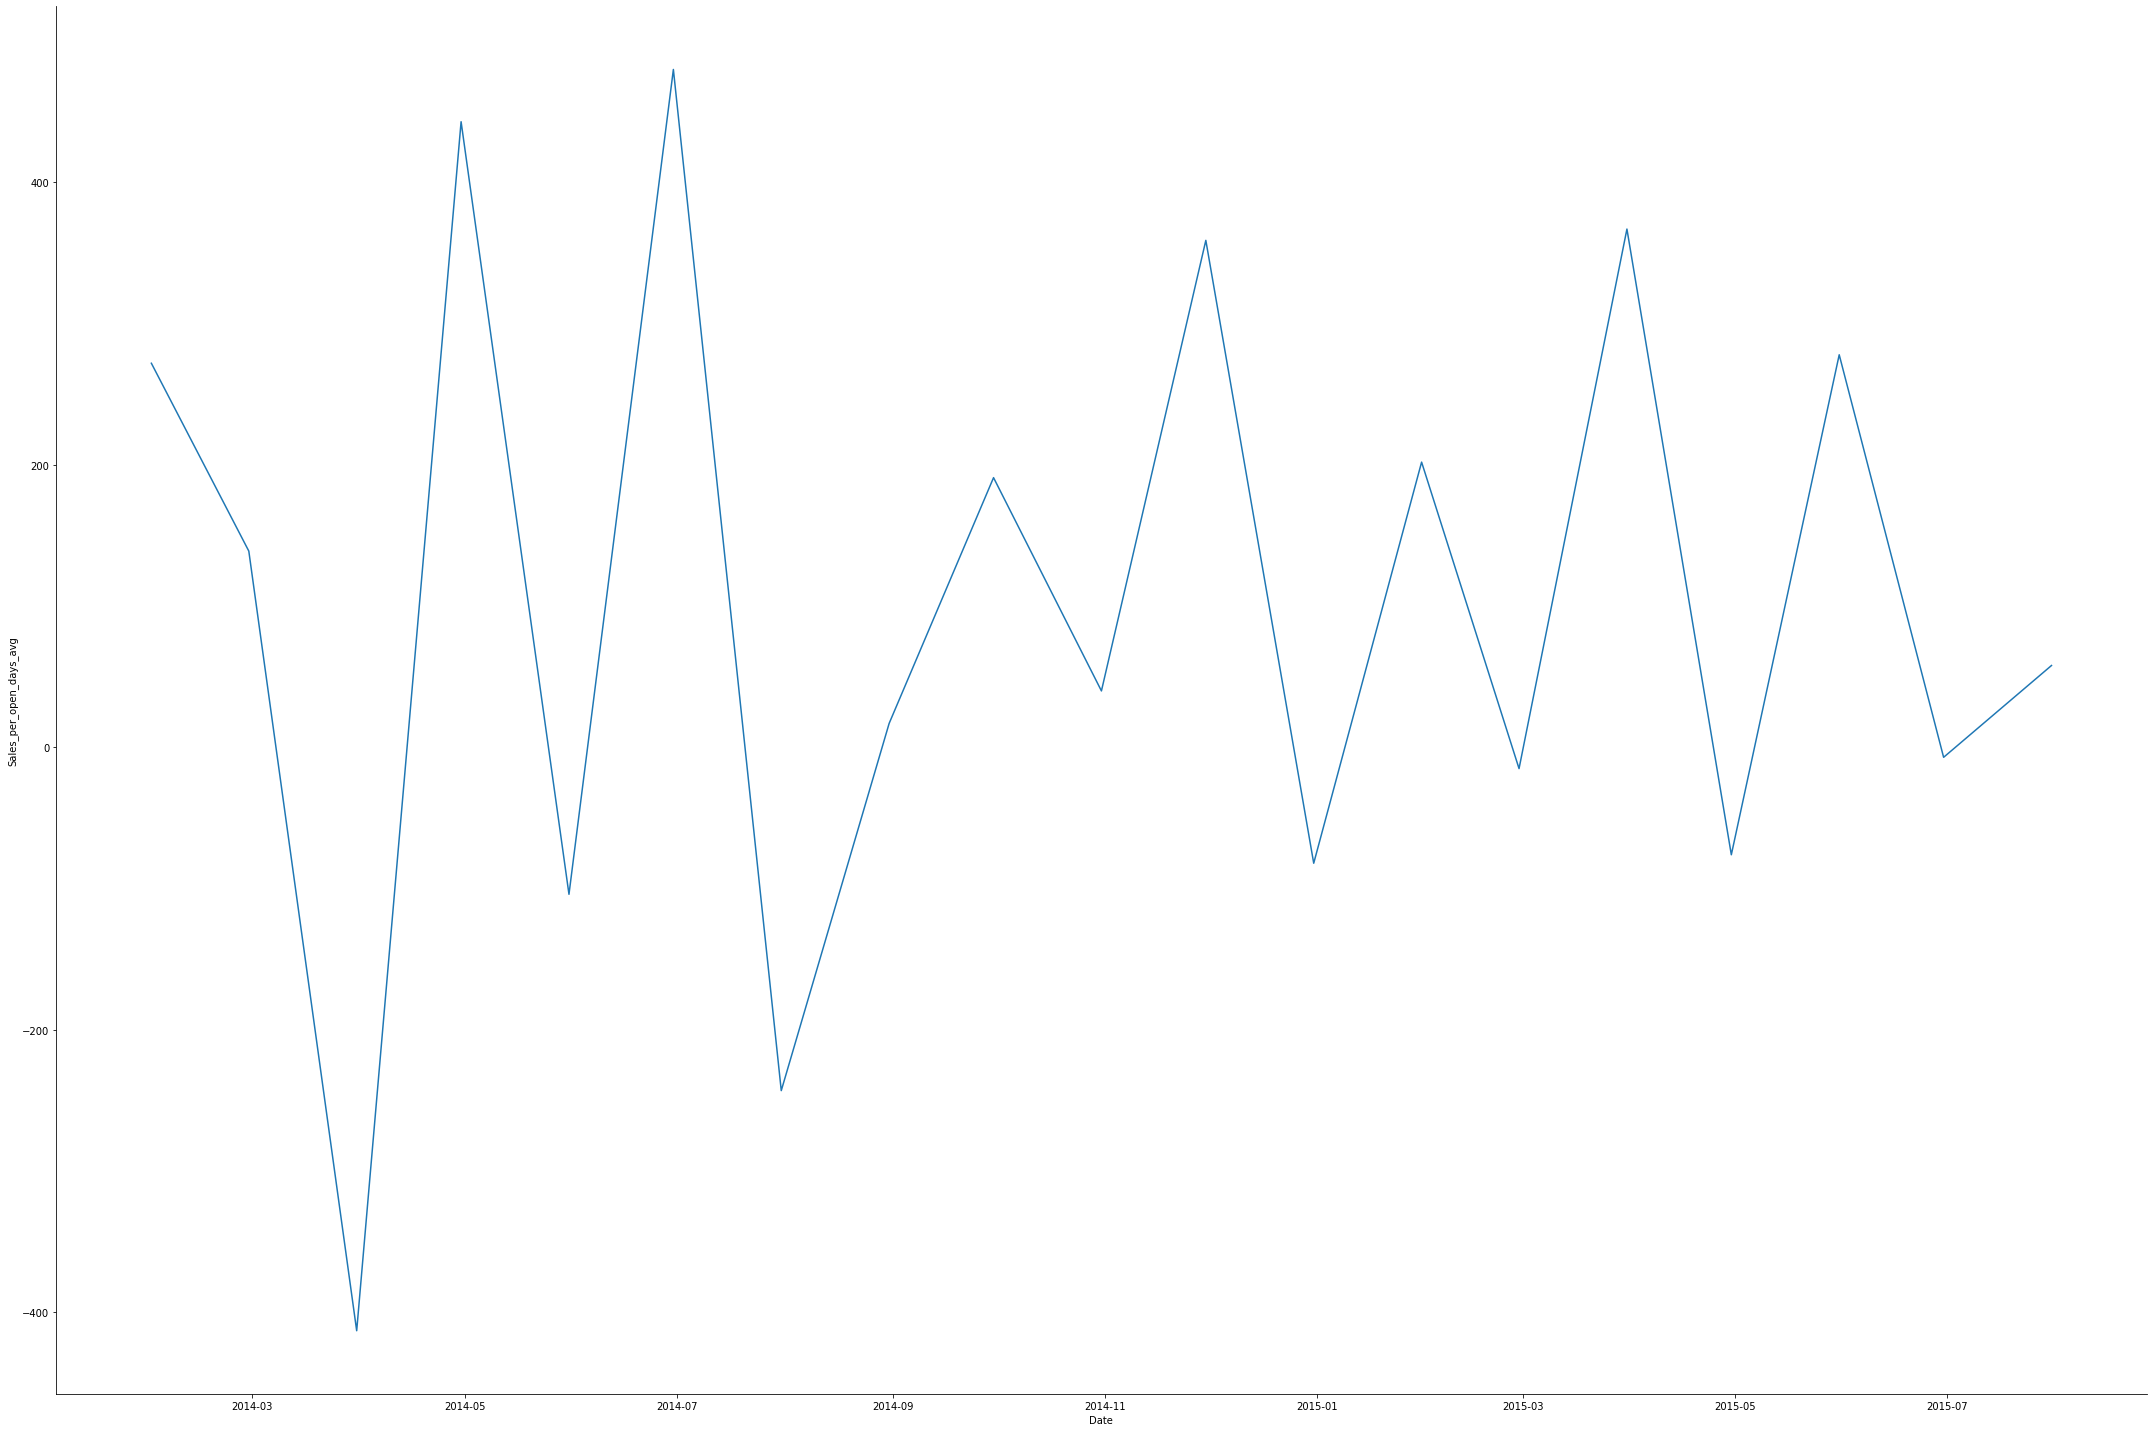

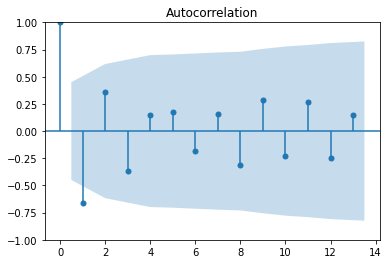

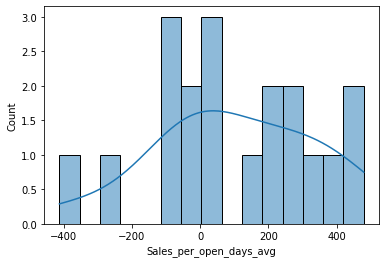

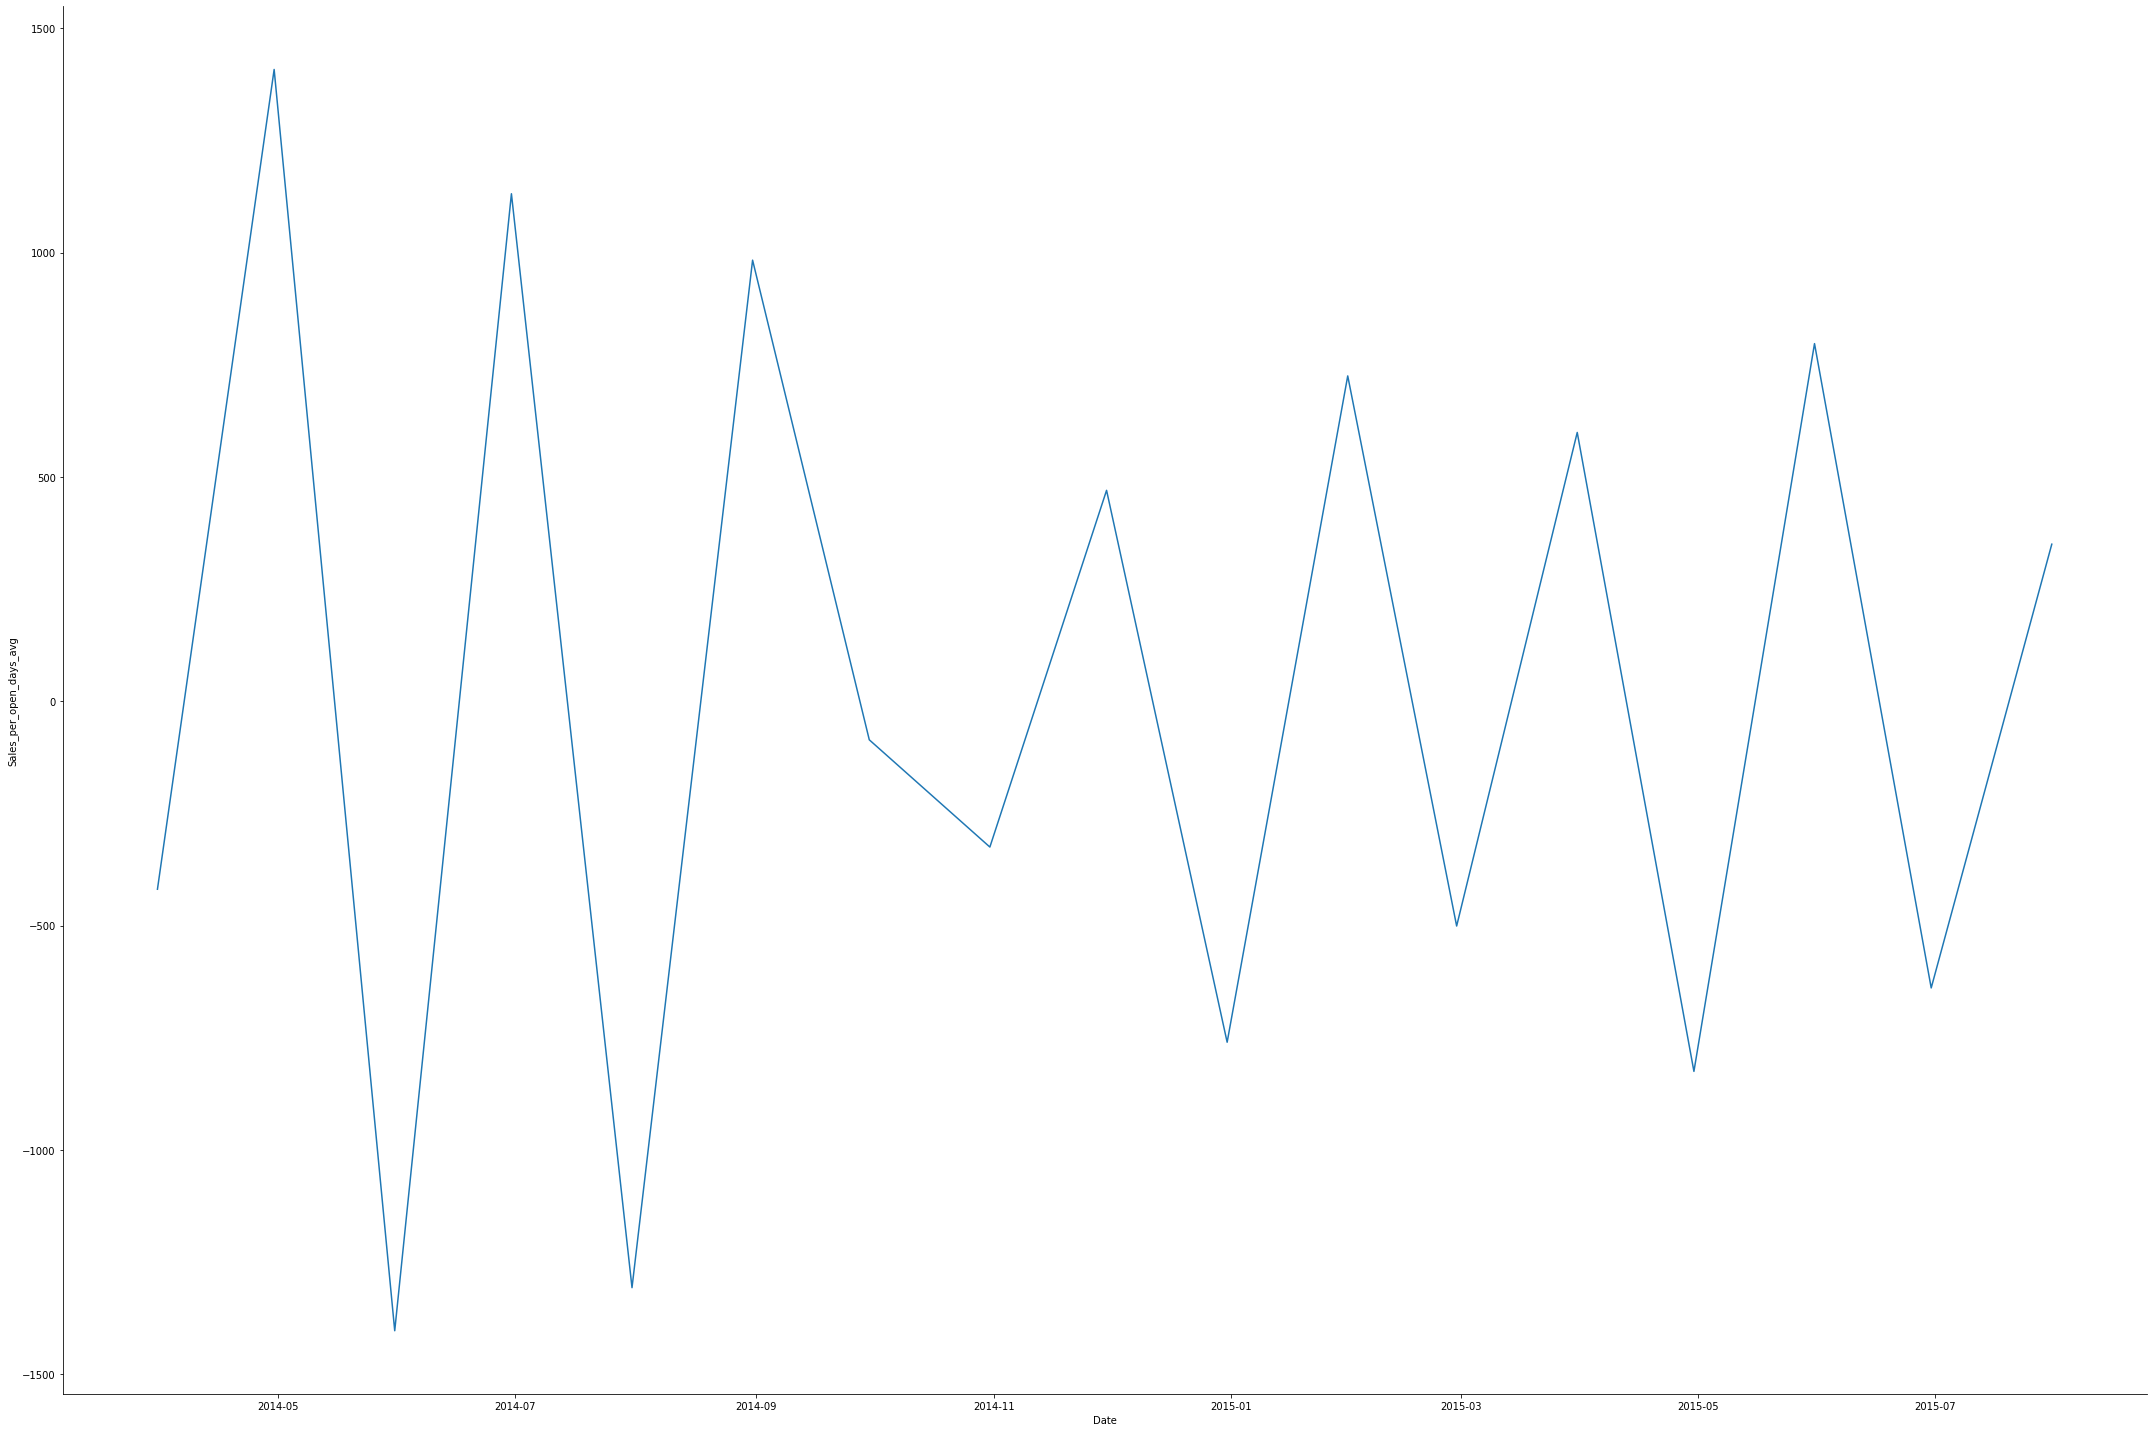

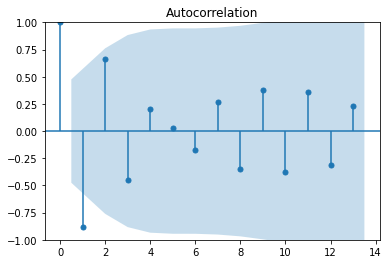

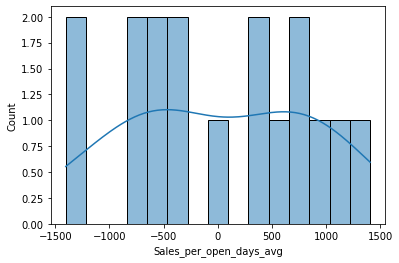

In [154]:
from statsmodels.tsa.statespace.tools import diff

# Compared to normalized to avg daily sales per month
# sns.relplot(data=df_store_1_monthly_sum.loc['2013-01':],
#             x='Month',
#             y='Sales_per_open_days_avg',
#             hue='Year',
#             kind='line',
#             markers=True,
#             height=20.0, aspect=1.5)
# plt.show()

y_t = df_store_1_monthly_sum['Sales_per_open_days_avg']
plot_series_acf_histogram(y_t, lags=13)

y_t_seasonal_diff = diff(series=y_t, k_diff=0, k_seasonal_diff=1, seasonal_periods=12)
plot_series_acf_histogram(y_t_seasonal_diff, lags=13)

y_t_first_diff = diff(series=y_t_seasonal_diff, k_diff=2)
plot_series_acf_histogram(y_t_first_diff, lags=13)

## Monthly | Time series decomposition in Trend, Seasonal and Residuals
Decompose to extract trend cycle for better ACF with the Seasonal component with yt = S+T+R cause we have a additive decompoition in _classical decomposition_ cause the changes in trend and seasonality are linear changing (trend) and constant (seasonality period).

1. [General Time series decomposition](https://otexts.com/fpp3/classical-decomposition.html)
2. [Very short intro to STL](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality)

### Additive classical decomposition
yt = St + Tt + Rt using MA (moving average). See the yearly same pattern of _S_ component.

1. [Additive classical decomposition with examples in python statsmodel](https://otexts.com/fpp3/classical-decomposition.html#additive-decomposition)

In [151]:
def plot_decompose_result(stl_decomp_result):
    f: plt.Figure = stl_decomp_result.a()
    f.set_size_inches(w=20, h=20)
    plt.show()

In [152]:
from numpy import log
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose

stl_decomp_result: DecomposeResult = seasonal_decompose(df_store_1_monthly_sum['Sales_per_open_days_avg'], model="additive", period=12, two_sided=True, extrapolate_trend=0)


plot_decompose_result(stl_decomp_result)

# check

# residuals are white noise now?
"MEAN(R): {}".format(stl_decomp_result.resid.mean())
"VAR(R) : {}".format(stl_decomp_result.resid.var())
# formal autocorrelation test of residuals -> small p-value means each lag correlation value is relative small
#acorr_ljungbox(stl_decomp_result.resid, lags=13)

f = plot_acf(stl_decomp_result.resid, lags=14)
plt.show()


AttributeError: 'DecomposeResult' object has no attribute 'a'

### STL decomposition

In [ ]:
from matplotlib.figure import Figure
from statsmodels.tsa._stl import STL

# The period of 12 is inferred by the DataFrame's index frquency M and assumed to be 12 using 2x12-MA for even number
stl = STL(df_store_1_monthly_sum['Sales_per_open_days_avg'], trend=13, period=12)
stl_decomp_result: DecomposeResult  = stl.fit()

plot_decompose_result(stl_decomp_result)

f = plot_acf(stl_decomp_result.resid, lags=14)
plt.show()


# residuals are white noise now?
"MEAN(R): {}".format(stl_decomp_result.resid.mean())
"VAR(R) : {}".format(stl_decomp_result.resid.var())

# Auto-regression | Forecast monthly sales trend from STL decompsition with seasonal ARIMA

In [ ]:
from statsmodels.tsa.ar_model import AutoReg, AutoRegResults
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

X = df_store_1_monthly_sum['Sales']

for X_train_idx, X_test_idx in TimeSeriesSplit(n_splits=5, test_size=2).split(X):
    y_train = X.iloc[X_train_idx]
    regressor: AutoReg = AutoReg(endog=y_train, lags=[12])
    model_fit = regressor.fit()
    print('Coefficients: %s' % model_fit.params)
    result: AutoRegResults = model_fit.predict(start=20, end=22)
    result


